### Sankey and chord diagrams for diagnostics of trade bilateralization

In [1]:
# Import packages
import os
import sys
import pandas as pd
import numpy as np
import logging
import yaml
import message_ix
import ixmp
import itertools

import plotly.graph_objects as go
import bokeh
import holoviews as hv
from holoviews import dim, opts

from message_ix_models.tools.bilateralize.bilateralize import *
from message_ix_models.tools.bilateralize.build_sankey import *
from message_ix_models.util import package_data_path
from ixmp import Platform

# Bring in configuration
config, config_path = load_config(project_name = 'newpathways', 
                                  config_name = 'config.yaml')
data_path = os.path.dirname(config_path)

# Connect to ixmp
mp = ixmp.Platform()

# Build Sankey dataframes
def build_sankeydf(commodities:dict,
                   model_name:str, 
                   scenario_name:str):
    
    scen = message_ix.Scenario(mp, model=model_name, scenario=scenario_name)
    
    activity = scen.var("ACT")
    activity = activity[['node_loc', 'technology', 'year_act', 'lvl']].drop_duplicates().reset_index()
    activity = activity.groupby(['node_loc', 'technology', 'year_act'])['lvl'].sum().reset_index()
    
    hist_activity = scen.par('historical_activity')
    hist_activity = hist_activity[['node_loc', 'technology', 'year_act', 'value']].drop_duplicates().reset_index()
    hist_activity = hist_activity.groupby(['node_loc', 'technology', 'year_act'])['value'].sum().reset_index()
    hist_activity = hist_activity.rename(columns = {'value': 'lvl'})
    activity = pd.concat([hist_activity, activity])
    
    
    slist = [c + '_exp_' for c in commodities.keys()]
    sdf = activity[activity['technology'].str.contains('|'.join(slist))].copy()
    
    sdf['fuel'] = ''
    for c in commodities.keys():
        sdf['fuel'] = np.where(sdf['technology'].str.contains(c),
                               commodities[c],
                               sdf['fuel'])
        
    sdf['importer'] = 'R12_' + sdf['technology'].str.upper().str.split('_').str[-1]
    sdf = sdf.rename(columns = {'node_loc': 'exporter',
                                'lvl': 'value',
                                'year_act': 'year'})
    sdf = sdf[['year', 'exporter', 'importer', 'fuel', 'value']]
    
    return sdf

#### Build dataframe

In [2]:
# Build data
df = build_sankeydf(commodities = {'gas_piped': 'Pipeline Gas',
                                   'LNG_shipped': 'Shipped LNG'},
                    model_name = "NP_SSP2_6.2", scenario_name = "pipelines_LNG")
df = df[df['value'] > 1]

Existing index sets of 'ACTIVITY_BOUND_LO' [] do not match ('node', 'technology', 'year', 'mode', 'time')
Existing index sets of 'ACTIVITY_BOUND_UP' [] do not match ('node', 'technology', 'year', 'mode', 'time')
Existing index sets of 'ACTIVITY_BY_RATING' [] do not match ('node', 'technology', 'year', 'commodity', 'level', 'time', 'rating')
Existing index sets of 'ACTIVITY_CONSTRAINT_LO' [] do not match ('node', 'technology', 'year', 'time')
Existing index sets of 'ACTIVITY_CONSTRAINT_UP' [] do not match ('node', 'technology', 'year', 'time')
Existing index sets of 'ACTIVITY_RATING_TOTAL' [] do not match ('node', 'technology', 'year', 'year', 'commodity', 'level', 'time')
Existing index names of 'ACTIVITY_RATING_TOTAL' [] do not match ('node', 'technology', 'year_vtg', 'year', 'commodity', 'level', 'time')
Existing index sets of 'ACTIVITY_SOFT_CONSTRAINT_LO' [] do not match ('node', 'technology', 'year', 'time')
Existing index sets of 'ACTIVITY_SOFT_CONSTRAINT_UP' [] do not match ('nod

#### Sankey Diagrams

#### Chord Diagrams

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
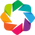

In [3]:
# Create chord (inflated)
hv.extension('bokeh')
hv.output(size=300)

def create_chord(year:int, fuel:str):
    cdf = df[df['year'] == year]
    cdf = cdf[cdf['fuel'] == fuel]
    cdf = cdf[['exporter', 'importer', 'value']]
    
    cdf_nodes = pd.DataFrame(set(list(cdf['exporter'].unique()) + list(cdf['importer'].unique())))
    cdf_nodes = cdf_nodes.sort_values(by = 0).reset_index(drop = True)
    cdf_nodes = cdf_nodes.reset_index()
    cdf_nodes.columns = ['node', 'message_region']
  
    cdf = cdf.merge(cdf_nodes, left_on = 'exporter', right_on = 'message_region', how = 'left')
    cdf = cdf.merge(cdf_nodes, left_on = 'importer', right_on = 'message_region', how = 'left')
  
    cdf = cdf.rename(columns = {'node_x': 'source',
                  'node_y': 'target'})
    cdf = cdf[['source', 'target', 'value']]
    cdf['value'] = cdf['value']
    
    cdf_nodes = hv.Dataset(cdf_nodes, 'index')

    if len(cdf) > 20:
        chord_out = hv.Chord((cdf, cdf_nodes))
    else:
        # Inflate dataframe
        inflate_cdf = pd.DataFrame()
        for i in list(cdf.index):
            nr = cdf['value'][i].astype(int)
            idf = pd.DataFrame(np.empty((nr, 3)) * 1) 
            idf.columns = ['source', 'target', 'value']
            idf['source'] = cdf['source'][i]
            idf['target'] = cdf['target'][i]
            idf['value'] = 2
            inflate_cdf = pd.concat([inflate_cdf, idf])
            
        inflate_cdf = inflate_cdf.reset_index(drop = True)
        inflate_cdf['value'] = 1
        chord_out = hv.Chord((inflate_cdf, cdf_nodes))
        
    chord_out.opts(opts.Chord(edge_cmap = 'Category20', edge_color=dim('source').str(),
                              node_cmap = 'Category20', node_color=dim('message_region').str(),
                              labels='message_region'))
    chord_out.opts(label_text_font_size='16pt')

    return chord_out

In [4]:
create_chord(year = 2025, fuel = "Pipeline Gas")

:Chord   [source,target]   (value)

In [5]:
create_chord(year = 2050, fuel = "Pipeline Gas")

:Chord   [source,target]   (value)

In [6]:
create_chord(year = 2100, fuel = "Pipeline Gas")

:Chord   [source,target]   (value)

In [7]:
create_chord(year = 2025, fuel = "Shipped LNG")

:Chord   [source,target]   (value)

In [8]:
create_chord(year = 2040, fuel = "Shipped LNG")

:Chord   [source,target]   (value)

In [9]:
create_chord(year = 2100, fuel = "Shipped LNG")

:Chord   [source,target]   (value)